In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
layers = keras.layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

print("keras version", keras.__version__)
print("numpy version", np.__version__)

keras version 2.11.0
numpy version 1.24.2


In [2]:
# Download Fashion MNIST and normalitze it to [0,1]
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (X_test, y_test) = fashion_mnist.load_data()
train_images = train_images[...,np.newaxis] / 255

In [3]:
len(train_images)

60000

In [4]:
print(train_images.shape)
print(train_labels.shape)


(60000, 28, 28, 1)
(60000,)


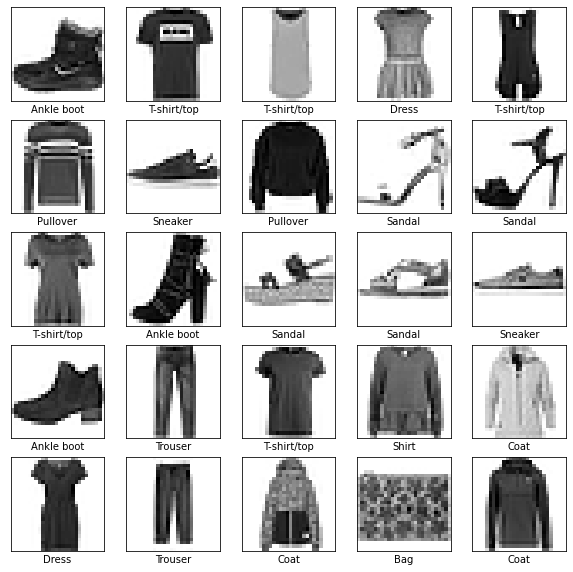

In [5]:
#### check the data we got
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images[i]).astype(int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

Let's split the original training data into 80% training and 20% validation. This helps to see weather we're over-fitting on the training data and weather we should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=12345)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


In [8]:
# (Handcrafted) convolution filters
cross =  [[-1,1,-1],
          [1,1,1],
          [-1,1,-1]]

sobel1 = [[1,0,-1],
          [2,0,-2],
          [1,0,-1]]

sobel2 = np.array(sobel1).T

emboss = [[-1,-1, 0],
          [-1, 0, 1],
          [ 0, 1, 1]]

sharpen =[[-1,-1,-1],
          [-1, 9,-1],
          [-1,-1,-1]]

sharpen =[[ 1, 1, 1],
          [ 1, -7, 1],
          [ 1, 1, 1]]

mean    =[[ 1, 1, 1],
          [ 1, 1, 1],
          [ 1, 1, 1]]

### Model 

For current task we might try to use for example CNN with 3 Convolutional Layers.
Convolution is the application of a filter over an image.
Convolution transforms the input image into a different image, this output image is called a feature map.

In [9]:
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)
# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
# X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [10]:
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])#, name="Sequential 3L")

Since we are dealing with classification problem of 10 classes, which is more than 2 classes,
the softmax activation function on the output layer will help us to get probability distribution over the possible classes.

In [11]:
# Build and check the shapes of CNN 
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

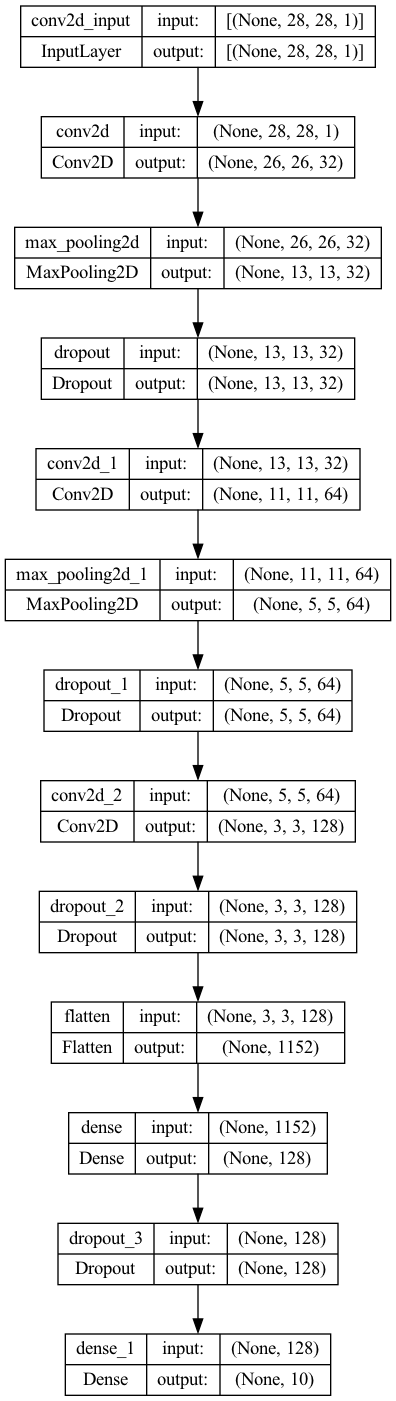

In [12]:
# Plot the Keras model as a graph
from tensorflow.keras.utils import plot_model
plot_model(cnn_model, show_shapes=True)

### Training preparations
After building the CNN model, we have to compile it. Use Adam optimizer instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data

In [13]:
from tensorflow.keras.optimizers.legacy import Adam

cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-4),
              metrics=['acc'])
# cnn_model.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=["acc"]) # loss='categorical_crossentropy',

### Training

In [14]:
batch_size = 128

cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/30


2023-03-12 17:05:17.402821: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


375/375 [==============================] - 7s 19ms/step - loss: 1.0053 - acc: 0.6342 - val_loss: 0.6069 - val_acc: 0.7715
Epoch 2/30
375/375 [==============================] - 8s 21ms/step - loss: 0.6268 - acc: 0.7638 - val_loss: 0.5237 - val_acc: 0.8048
Epoch 3/30
375/375 [==============================] - 8s 22ms/step - loss: 0.5492 - acc: 0.7942 - val_loss: 0.4584 - val_acc: 0.8298
Epoch 4/30
375/375 [==============================] - 9s 23ms/step - loss: 0.4997 - acc: 0.8126 - val_loss: 0.4164 - val_acc: 0.8487
Epoch 5/30
375/375 [==============================] - 8s 21ms/step - loss: 0.4640 - acc: 0.8278 - val_loss: 0.3952 - val_acc: 0.8587
Epoch 6/30
375/375 [==============================] - 8s 22ms/step - loss: 0.4347 - acc: 0.8398 - val_loss: 0.3696 - val_acc: 0.8716
Epoch 7/30
375/375 [==============================] - 8s 22ms/step - loss: 0.4143 - acc: 0.8471 - val_loss: 0.3503 - val_acc: 0.8758
Epoch 8/30
375/375 [==============================] - 8s 22ms/step - loss: 0.397

In [15]:
cnn_model.optimizer.lr = 0.0001 

In [16]:
cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/30
375/375 [==============================] - 9s 24ms/step - loss: 0.2406 - acc: 0.9107 - val_loss: 0.2287 - val_acc: 0.9158
Epoch 2/30
375/375 [==============================] - 9s 24ms/step - loss: 0.2398 - acc: 0.9110 - val_loss: 0.2265 - val_acc: 0.9175
Epoch 3/30
375/375 [==============================] - 8s 21ms/step - loss: 0.2360 - acc: 0.9135 - val_loss: 0.2238 - val_acc: 0.9175
Epoch 4/30
375/375 [==============================] - 8s 21ms/step - loss: 0.2369 - acc: 0.9126 - val_loss: 0.2263 - val_acc: 0.9171
Epoch 5/30
375/375 [==============================] - 8s 22ms/step - loss: 0.2339 - acc: 0.9126 - val_loss: 0.2259 - val_acc: 0.9171
Epoch 6/30
375/375 [==============================] - 8s 22ms/step - loss: 0.2324 - acc: 0.9134 - val_loss: 0.2239 - val_acc: 0.9182
Epoch 7/30
375/375 [==============================] - 8s 22ms/step - loss: 0.2316 - acc: 0.9143 - val_loss: 0.2232 - val_acc: 0.9189
Epoch 8/30
375/375 [==============================] - 9s 23ms/step - 

In [17]:
history = cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=40,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/40
375/375 [==============================] - 8s 23ms/step - loss: 0.1988 - acc: 0.9249 - val_loss: 0.2074 - val_acc: 0.9245
Epoch 2/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1969 - acc: 0.9259 - val_loss: 0.2124 - val_acc: 0.9225
Epoch 3/40
375/375 [==============================] - 8s 23ms/step - loss: 0.1952 - acc: 0.9273 - val_loss: 0.2088 - val_acc: 0.9244
Epoch 4/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1962 - acc: 0.9264 - val_loss: 0.2056 - val_acc: 0.9262
Epoch 5/40
375/375 [==============================] - 8s 23ms/step - loss: 0.1921 - acc: 0.9281 - val_loss: 0.2078 - val_acc: 0.9247
Epoch 6/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1936 - acc: 0.9266 - val_loss: 0.2074 - val_acc: 0.9258
Epoch 7/40
375/375 [==============================] - 9s 24ms/step - loss: 0.1944 - acc: 0.9276 - val_loss: 0.2065 - val_acc: 0.9252
Epoch 8/40
375/375 [==============================] - 9s 23ms/step - 

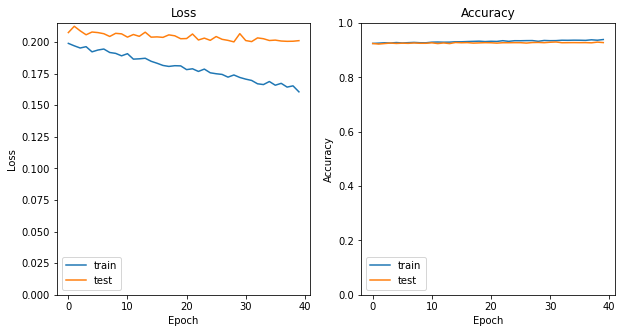

In [18]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

In [19]:
cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=40,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1620 - acc: 0.9398 - val_loss: 0.2044 - val_acc: 0.9274
Epoch 2/40
375/375 [==============================] - 8s 23ms/step - loss: 0.1616 - acc: 0.9389 - val_loss: 0.1991 - val_acc: 0.9292
Epoch 3/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1621 - acc: 0.9390 - val_loss: 0.2024 - val_acc: 0.9284
Epoch 4/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1606 - acc: 0.9398 - val_loss: 0.2011 - val_acc: 0.9301
Epoch 5/40
375/375 [==============================] - 9s 24ms/step - loss: 0.1610 - acc: 0.9394 - val_loss: 0.1994 - val_acc: 0.9283
Epoch 6/40
375/375 [==============================] - 8s 22ms/step - loss: 0.1612 - acc: 0.9384 - val_loss: 0.2019 - val_acc: 0.9276
Epoch 7/40
375/375 [==============================] - 9s 23ms/step - loss: 0.1561 - acc: 0.9414 - val_loss: 0.2014 - val_acc: 0.9299
Epoch 8/40
375/375 [==============================] - 9s 23ms/step - 

### Summary 

Forom the distribution of the Loss comparison we can already conclude that the model is overfitting the training data. In this situation having more data would help, or one could reduce the number of hidden layers of the model, since our data is not too complicated.

In general the performance of the model give us more than 90% of the accuracy.